In [116]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Activation
import warnings
import os
import cv2
import tensorflow as tf

In [117]:
# đường dẫn đến thư mục chứa dữ liệu
path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\Fish_Dataset_Segment1'
classes = [i for i in os.listdir(path) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [118]:
data = [] # mảng chứa dữ liệu
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append([img, folder])

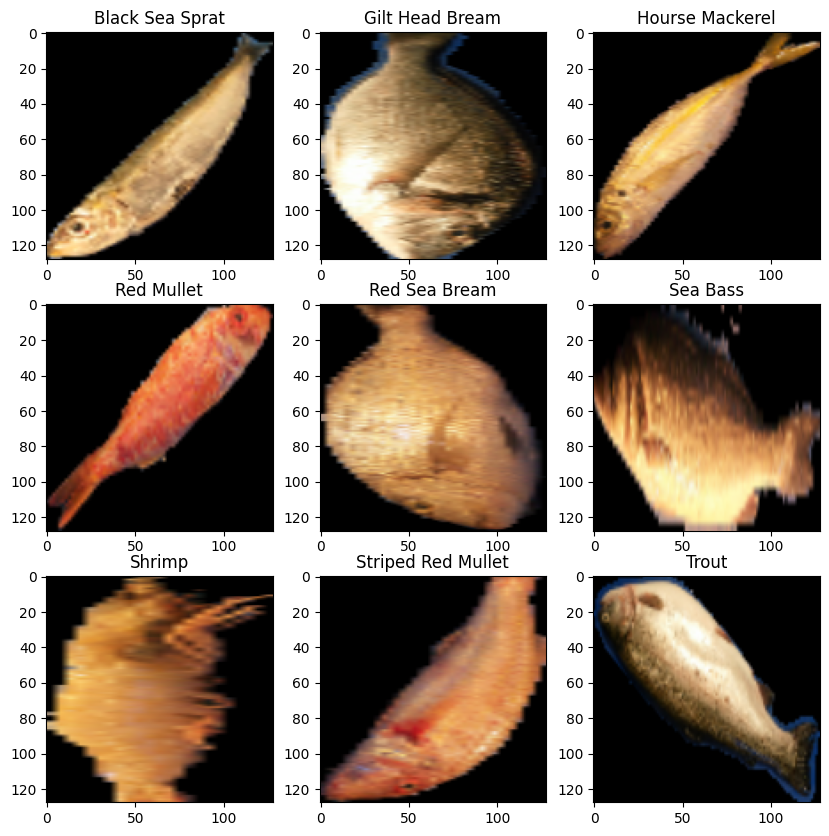

In [119]:
plt.figure(figsize=(10, 10))
# Thay thế bằng nhãn (label) bạn muốn hiển thị

for i, label in enumerate(classes):
    plt.subplot(3, 3, i+1)
    # Lọc dữ liệu theo nhãn
    filtered_data = [item for item in data if item[1] == label]
    # Chọn một ảnh ngẫu nhiên từ dữ liệu đã lọc
    random_image = filtered_data[np.random.randint(len(filtered_data))][0]
    plt.imshow(random_image)
    plt.title(label)

plt.show()


In [120]:
# tạo image và label từ data_test
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)
images = np.array(images)
labels = np.array(labels)

In [121]:
# chuấn hóa label thành dạng số
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [122]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(9000, 128, 128, 3)

In [123]:
h = images.shape[1] # chiều cao của ảnh
w = images.shape[2] # chiều rộng của ảnh
c = images.shape[3] # số kênh màu của ảnh

In [124]:
# biến đổi label thành one-hot encoding
labels  = tf.keras.utils.to_categorical(labels , num_classes=9)
labels 

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [125]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((7200, 128, 128, 3), (1800, 128, 128, 3), (7200, 9), (1800, 9))

In [126]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 800, 1: 800, 2: 800, 3: 800, 4: 800, 5: 800, 6: 800, 7: 800, 8: 800}

In [127]:
# tạo model
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(h, w, c)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# model.add(Conv2D(256, (5,5)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [128]:
callbacks = [ModelCheckpoint('model_segment.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')]
history = model.fit(train_images ,train_labels, batch_size=32, epochs=15, verbose=1, validation_data=(val_images, val_labels), callbacks= [callbacks])

Epoch 1/15
225/225 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.6507
Epoch 1: val_loss improved from inf to 5.25784, saving model to model_segment.hdf5
225/225 [==============================] - 215s 927ms/step - loss: 1.0461 - accuracy: 0.6507 - val_loss: 5.2578 - val_accuracy: 0.1111
Epoch 2/15
225/225 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.8406
Epoch 2: val_loss improved from 5.25784 to 3.25497, saving model to model_segment.hdf5
225/225 [==============================] - 200s 888ms/step - loss: 0.4939 - accuracy: 0.8406 - val_loss: 3.2550 - val_accuracy: 0.2239
Epoch 3/15
225/225 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8857
Epoch 3: val_loss did not improve from 3.25497
225/225 [==============================] - 192s 852ms/step - loss: 0.3570 - accuracy: 0.8857 - val_loss: 4.2951 - val_accuracy: 0.2567
Epoch 4/15
225/225 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0

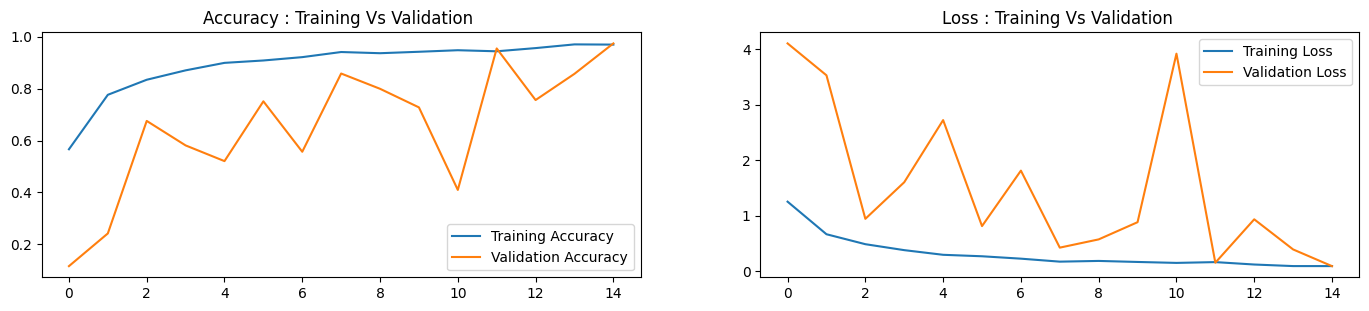

In [ ]:
# trực quan hóa quá trình train
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(15), accuracy, label='Training Accuracy')
plt.plot(range(15), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training Vs Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show();

In [ ]:
model = load_model('model_segment.hdf5') # load model đã lưu

In [ ]:
y_pred = model.predict(x=val_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(val_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)

57/57 [==============================] - 9s 155ms/step


In [ ]:
data_test = []
# path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset"
path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset_Segment'
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data_test.append([img, folder])

In [ ]:
# shuffle data_test
import random
random.shuffle(data_test)

In [ ]:
# tạo image và label từ data_test
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [ ]:
# chuấn hóa label
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [ ]:
# chuyển images thành numpy array và chuẩn hóa về khoảng [0, 1]
test_images = np.array(test_images)
test_images = test_images.astype('float32') / 255.0
test_images.shape

(430, 128, 128, 3)

In [ ]:
# biến đổi label thành one-hot encoding
test_labels  = tf.keras.utils.to_categorical(test_labels , num_classes=9)
test_labels 

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
loss,  acc = model.evaluate(test_images,test_labels)
loss, acc

14/14 [==============================] - 3s 217ms/step - loss: 0.7134 - accuracy: 0.7930


(0.7134097814559937, 0.7930232286453247)

In [ ]:
y_pred = model.predict(x=test_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(test_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)
# Đánh giá model trên tập test
print(classification_report(test_labels.argmax(axis=1), y_pred.argmax(axis=1), target_names=le.classes_));

14/14 [==============================] - 3s 185ms/step
                    precision    recall  f1-score   support

   Black Sea Sprat       0.89      0.78      0.83        50
   Gilt Head Bream       0.69      1.00      0.82        50
   Hourse Mackerel       0.97      0.62      0.76        50
        Red Mullet       1.00      0.96      0.98        50
     Red Sea Bream       0.55      0.90      0.68        50
          Sea Bass       0.74      0.56      0.64        50
            Shrimp       0.96      0.94      0.95        50
Striped Red Mullet       0.91      0.98      0.94        50
             Trout       0.36      0.13      0.20        30

          accuracy                           0.79       430
         macro avg       0.79      0.76      0.75       430
      weighted avg       0.80      0.79      0.78       430



In [104]:
-----------

SyntaxError: invalid syntax (353815310.py, line 1)

In [ ]:
model = Sequential()



model.add(Conv2D(32, (3,3), input_shape=(h, w, c)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

# model.add(Dense(9))


In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_43 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 activation_41 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 59, 59, 64)       

In [ ]:
feature_vector = model.predict(images)

29/29 [==============================] - 8s 235ms/step


In [ ]:
feature_vector.shape

(900, 2048)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

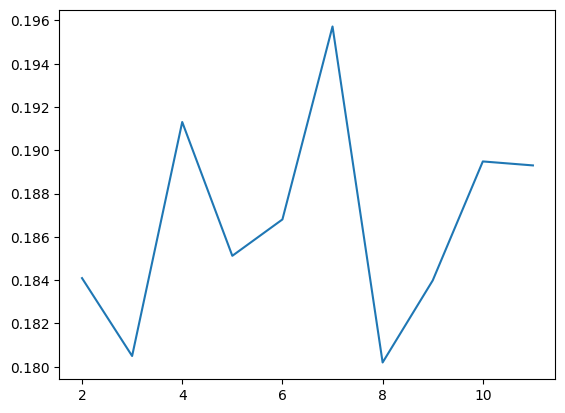

In [ ]:
warnings.filterwarnings("ignore")

scores = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i,n_init=10)
    kmeans.fit(feature_vector)
    scores.append(silhouette_score(feature_vector, kmeans.labels_))

plt.plot(range(2, 12), scores)

In [ ]:
from sklearn.cluster import KMeans
n_clusters=9

kmeans = KMeans(n_clusters,init='k-means++')
clusters = kmeans.fit_predict(feature_vector)

cluster_centers = kmeans.cluster_centers_


In [ ]:
# xác định vị trí các ảnh là tâm của các cluster
center_id = []
for i in range(n_clusters):
    center_id.append(np.where(clusters == i)[0][0])
center_id

[8, 3, 37, 5, 2, 0, 10, 29, 14]

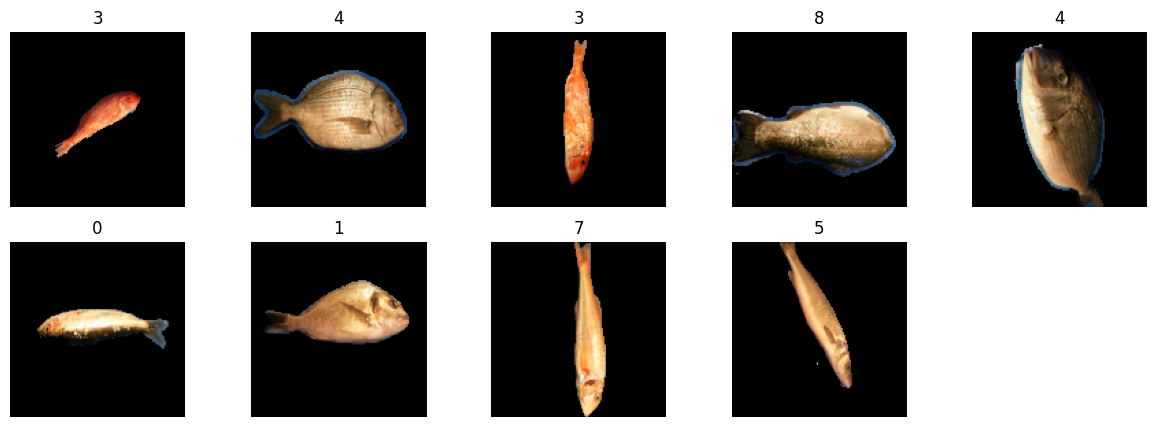

In [ ]:
import matplotlib.pyplot as plt

# Xác định vị trí các ảnh là tâm của các cụm
center_id = []
for i in range(n_clusters):
    center_id.append(np.where(clusters == i)[0][0])

# Vẽ các ảnh là tâm của các cụm
plt.figure(figsize=(15, 5))
for i in range(n_clusters):
    plt.subplot(2, 5, i+1)
    center_image = images[center_id[i]]
    center_image = center_image.reshape((128, 128, 3))
    plt.imshow(center_image)
    plt.axis('off')
    plt.title(labels[center_id[i]])

plt.show()


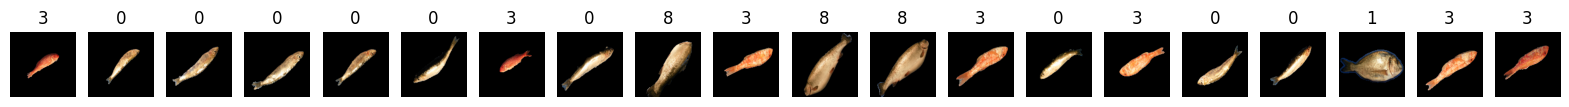

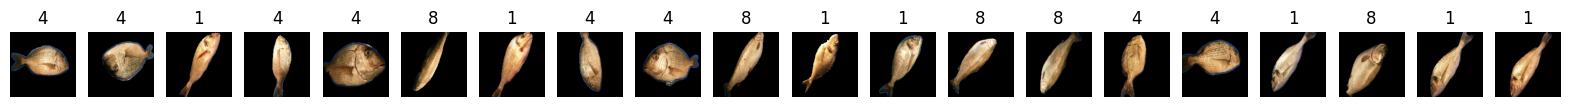

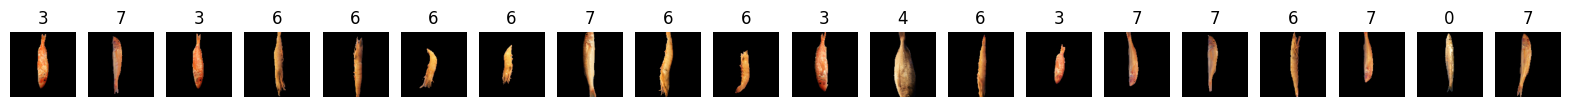

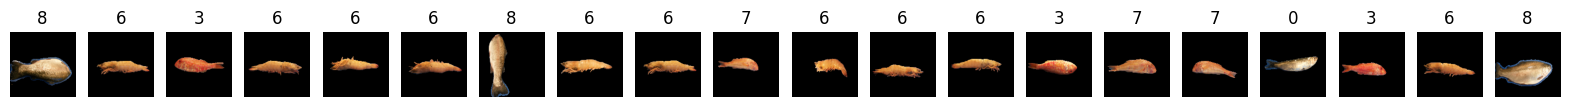

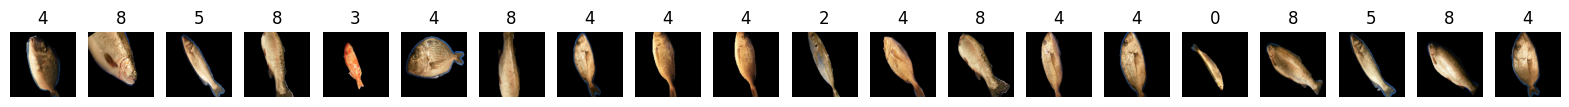

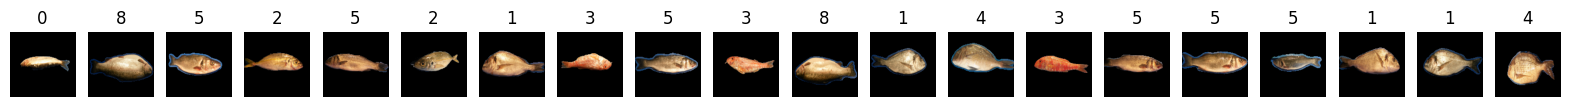

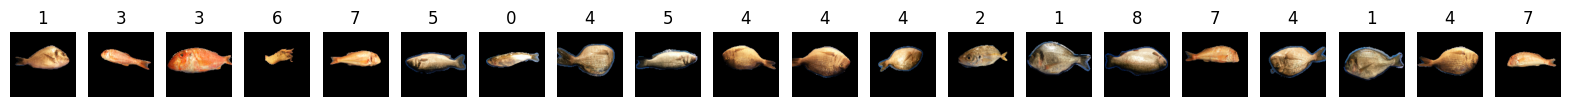

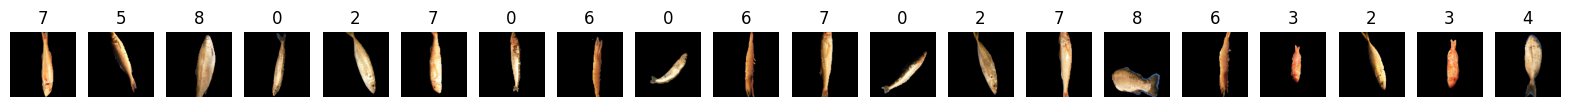

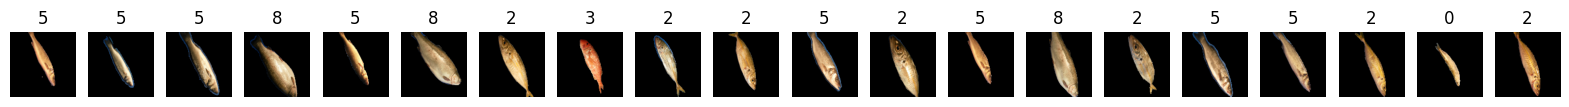

In [ ]:
import matplotlib.pyplot as plt

# Reshape cluster centers to match image dimensions
cluster_centers = np.array(kmeans.cluster_centers_)

num_clusters = cluster_centers.shape[0]
images_per_row = 20

# Display clusters
for cluster_id in range(num_clusters):
    cluster_center = cluster_centers[cluster_id]

    # Create a new row for each cluster
    plt.figure(figsize=(20, 1))

    # Plot the cluster center as the first image in the row
    plt.subplot(1, images_per_row + 1, 1)
    plt.imshow(images[cluster_id].reshape(128,128,3))
    plt.title(labels[cluster_id])
    plt.axis('off')

    # Get indices of images in the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]

    # Plot the images in the cluster
    for i, img_idx in enumerate(cluster_indices[:images_per_row]):
        img = images[img_idx]
        plt.subplot(1, images_per_row, i+1)
        plt.imshow(img.reshape(128,128,3))
        plt.title(labels[img_idx])
        plt.axis('off')

    plt.show()

In [ ]:
-------------------

SyntaxError: invalid syntax (3792574614.py, line 1)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
import keras
from sklearn.cluster import KMeans
from keras.models import Model

In [ ]:
model =   ResNet50(weights='imagenet', include_top=False, input_shape=(h, w,c))

In [ ]:
def extract_vector(data_holder):

    resnet_feature_list = []

    for im in data_holder:

        # im = image.img_to_array(im) 

        img = preprocess_input(np.expand_dims(im, axis=0))

        resnet_feature = model.predict(img)

        resnet_feature_np = np.array(resnet_feature)

        resnet_feature_list.append(resnet_feature_np.flatten())
    return np.array(resnet_feature_list)

In [ ]:
array = extract_vector(images)

1/1 [==============================] - 0s 60ms/step


In [ ]:
array.shape

(900, 32768)

In [ ]:
kmeans = KMeans(n_clusters=9)
# array = array.reshape(array.shape[0],-1)
clusters = kmeans.fit_predict(array)

In [ ]:
# xác định vị trí các ảnh là tâm của các cluster
center_id = []
for i in range(9):
    center_id.append(np.where(clusters == i)[0][0])
center_id

[30, 2, 0, 1, 8, 45, 29, 15, 24]

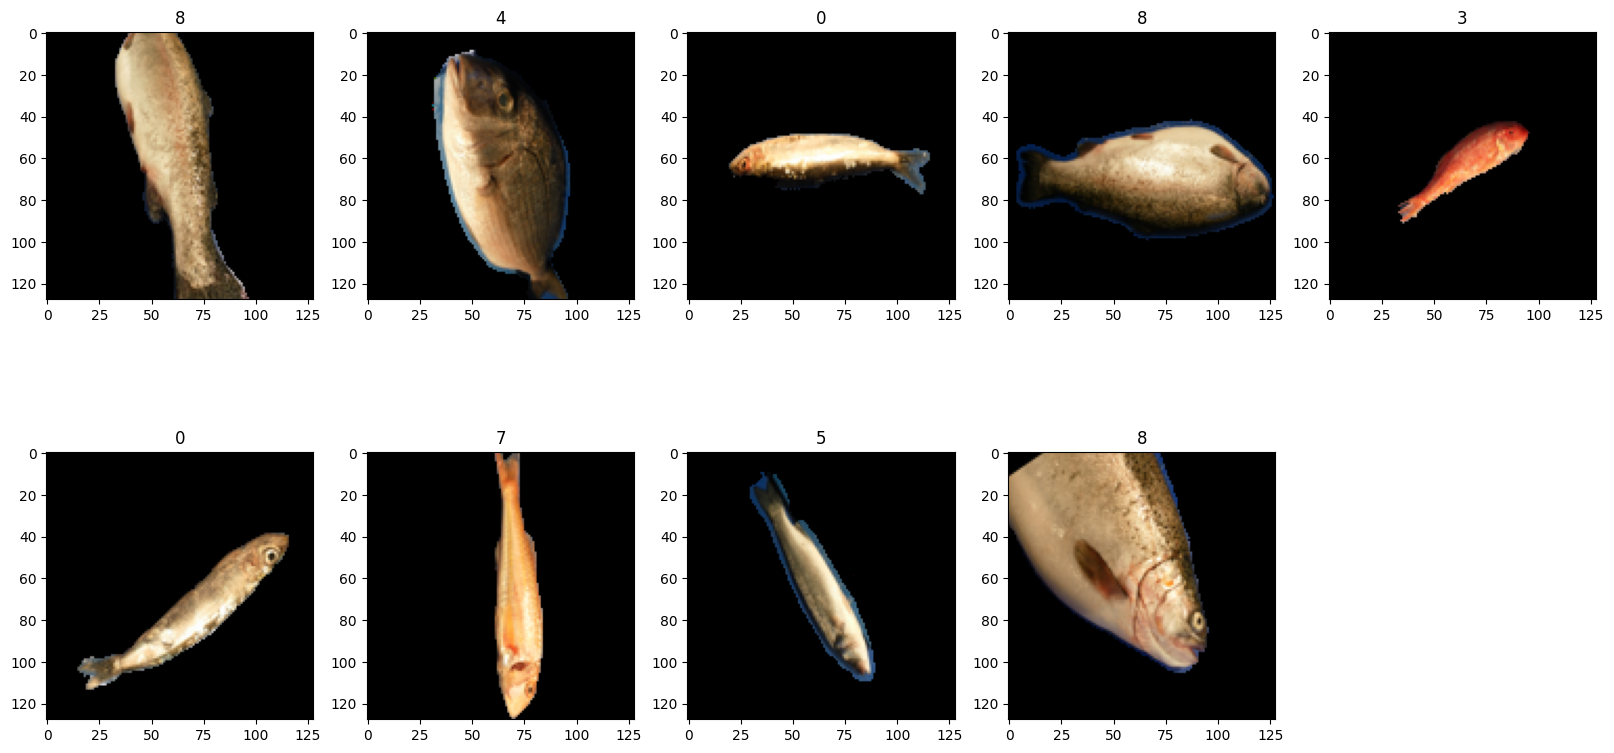

In [ ]:
# in ra các ảnh là tâm của các cluster
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[center_id[i]].reshape(128, 128, 3))
    # plt.title(i)
    plt.title(labels[center_id[i]])

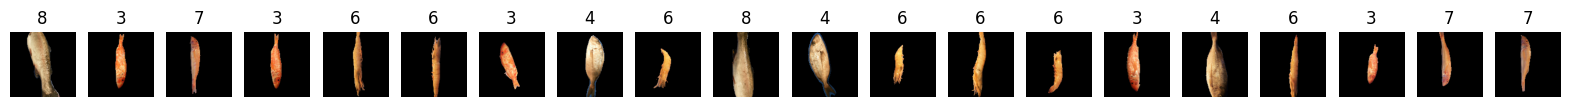

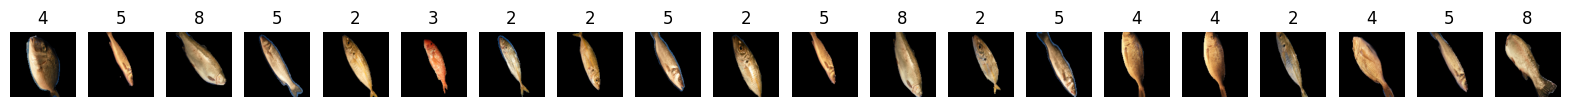

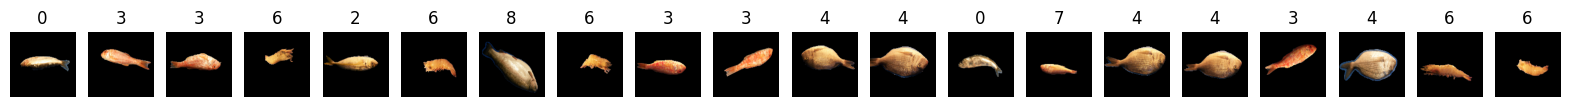

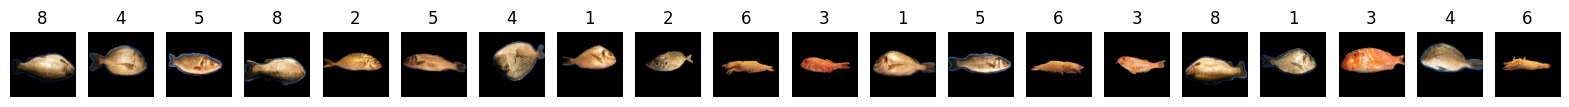

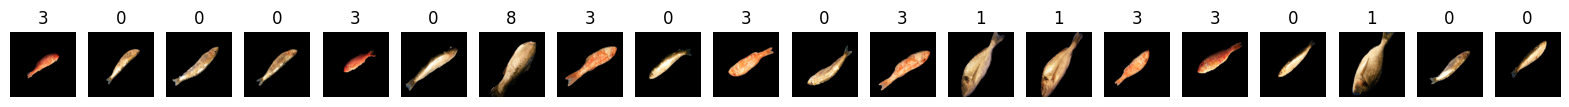

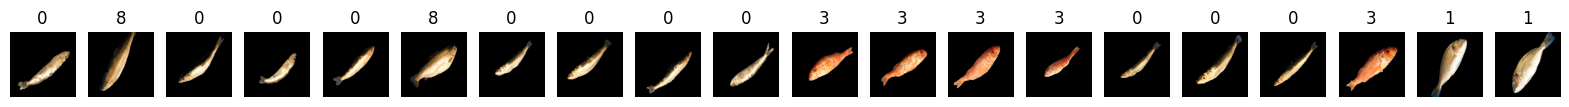

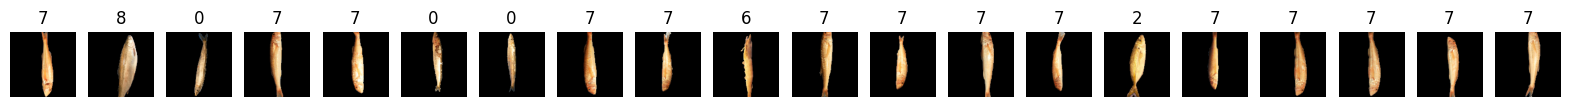

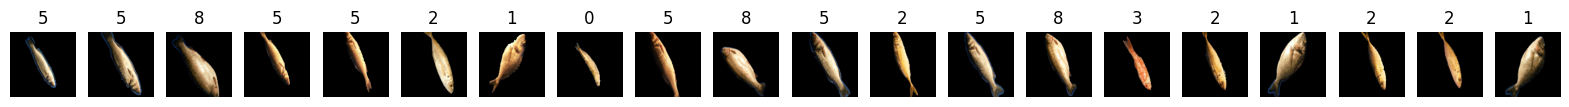

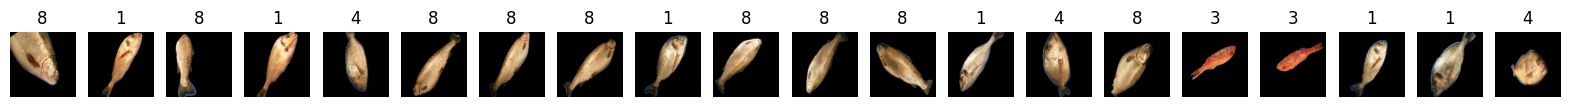

In [ ]:
import matplotlib.pyplot as plt

# Reshape cluster centers to match image dimensions
cluster_centers = np.array(kmeans.cluster_centers_)

num_clusters = cluster_centers.shape[0]
images_per_row = 20

# Display clusters
for cluster_id in range(num_clusters):
    cluster_center = cluster_centers[cluster_id]

    # Create a new row for each cluster
    plt.figure(figsize=(20, 1))

    # Plot the cluster center as the first image in the row
    plt.subplot(1, images_per_row + 1, 1)
    plt.imshow(images[cluster_indices[0]].reshape(128,128,3))
    plt.title(labels[cluster_indices[0]])
    plt.axis('off')

    # Get indices of images in the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]

    # Plot the images in the cluster
    for i, img_idx in enumerate(cluster_indices[:images_per_row]):
        img = images[img_idx]
        plt.subplot(1, images_per_row, i+1)
        plt.imshow(img.reshape(128,128,3))
        plt.title(labels[img_idx])
        plt.axis('off')

    plt.show()

In [ ]:
---

SyntaxError: invalid syntax (1947214667.py, line 1)

# GOOLENET

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

# Tải cấu trúc GoogLeNet (InceptionResNetV2)
model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(h,w,c))


In [ ]:
feature = model.predict(images)

29/29 [==============================] - 23s 662ms/step


In [ ]:
feature.shape

(900, 2, 2, 1536)

In [ ]:
feature = feature.reshape(feature.shape[0],-1)

In [ ]:
kmeans = KMeans(n_clusters=9)
clusters = kmeans.fit_predict(feature)

In [ ]:
# xác định vị trí các ảnh là tâm của các cluster
center_id = []
for i in range(9):
    center_id.append(np.where(clusters == i)[0][0])
center_id

[8, 29, 16, 3, 1, 0, 5, 42, 14]

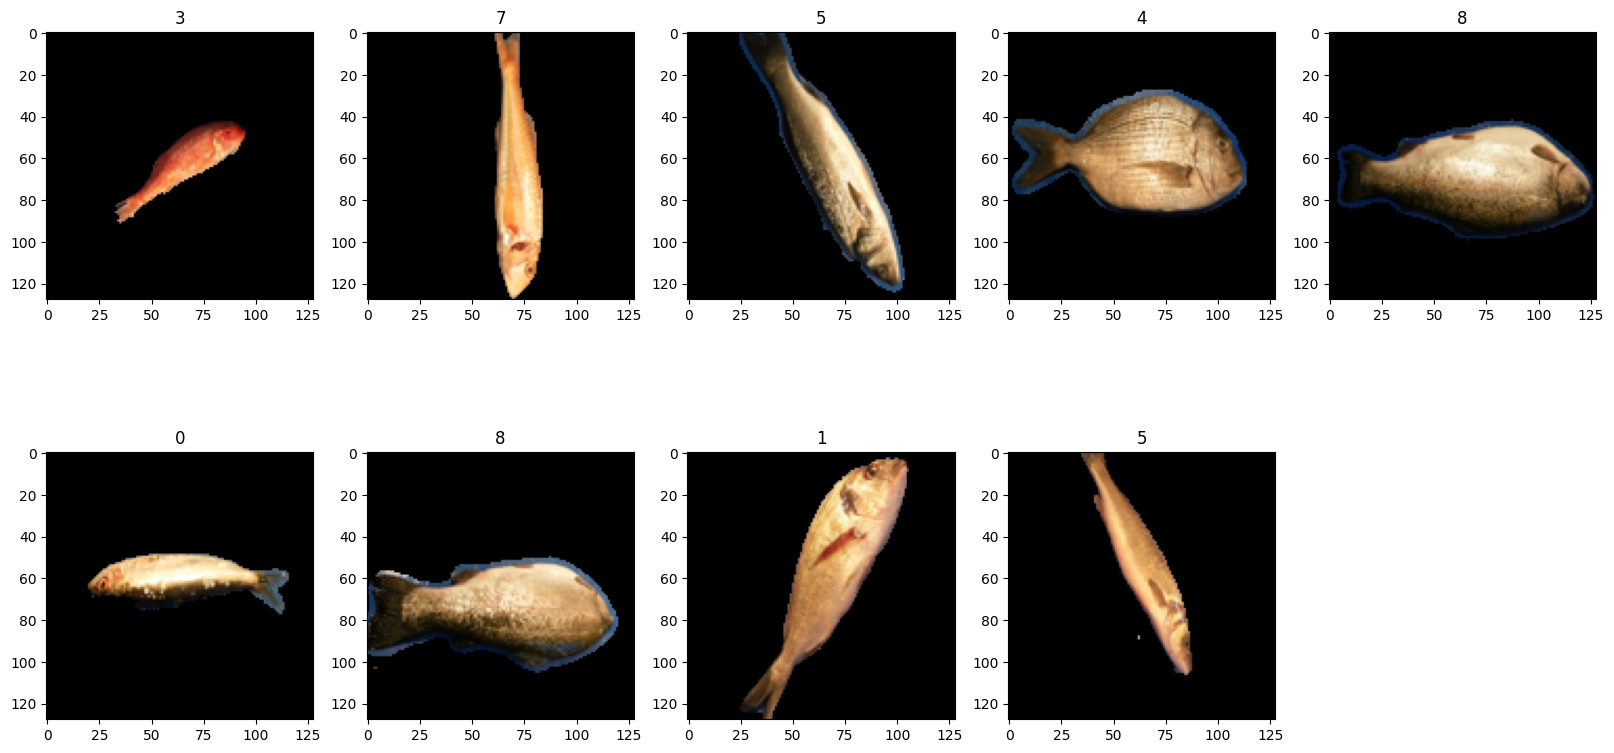

In [ ]:
# in ra các ảnh là tâm của các cluster
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[center_id[i]].reshape(128, 128, 3))
    # plt.title(i)
    plt.title(labels[center_id[i]])

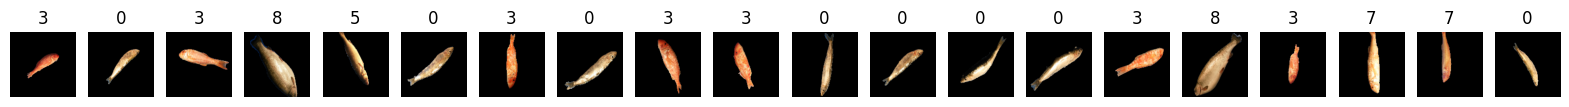

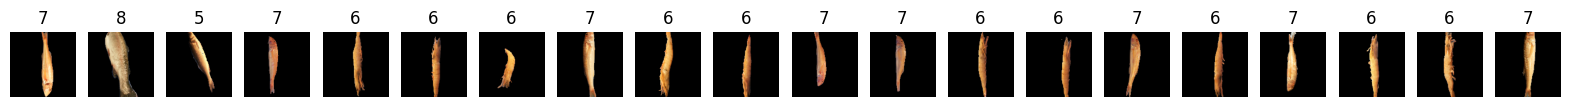

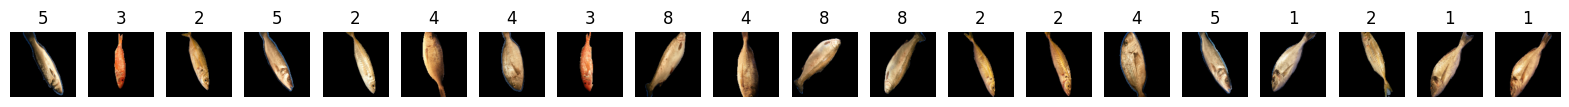

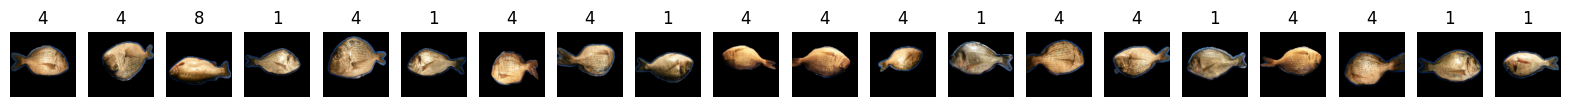

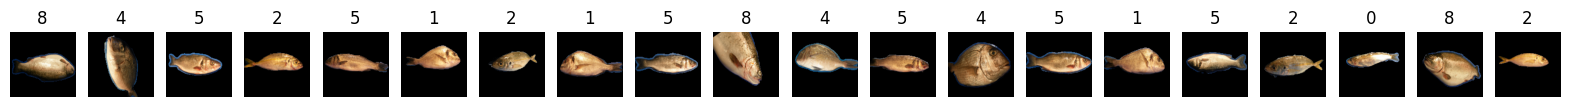

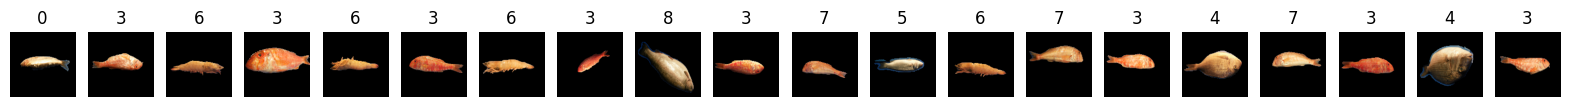

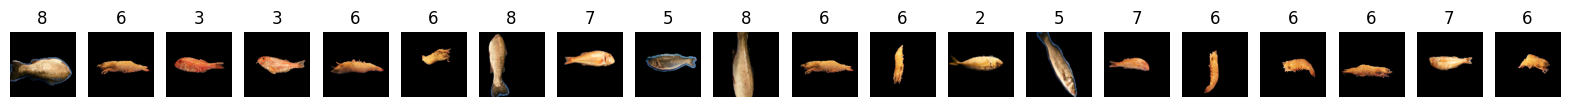

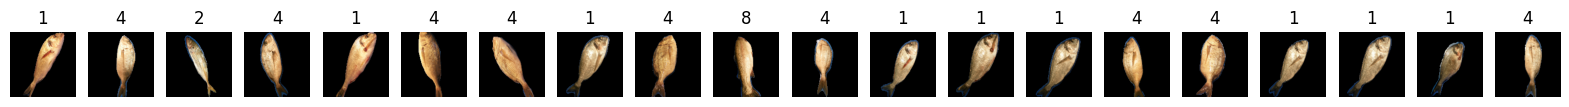

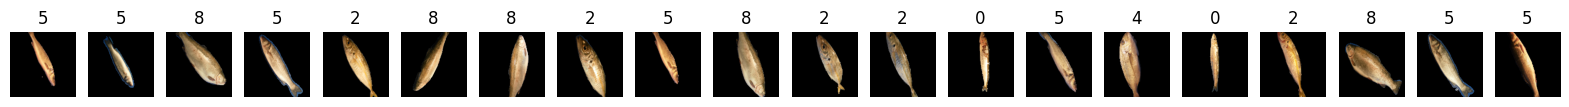

In [ ]:
import matplotlib.pyplot as plt

# Reshape cluster centers to match image dimensions
cluster_centers = np.array(kmeans.cluster_centers_)

num_clusters = cluster_centers.shape[0]
images_per_row = 20

# Display clusters
for cluster_id in range(num_clusters):
    cluster_center = cluster_centers[cluster_id]

    # Create a new row for each cluster
    plt.figure(figsize=(20, 1))

    # Plot the cluster center as the first image in the row
    plt.subplot(1, images_per_row + 1, 1)
    plt.imshow(images[cluster_id].reshape(128,128,3))
    plt.title(labels[cluster_id])
    plt.axis('off')

    # Get indices of images in the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]

    # Plot the images in the cluster
    for i, img_idx in enumerate(cluster_indices[:images_per_row]):
        img = images[img_idx]
        plt.subplot(1, images_per_row, i+1)
        plt.imshow(img.reshape(128,128,3))
        plt.title(labels[img_idx])
        plt.axis('off')

    plt.show()

# mô hinnhf kết hợp


In [ ]:
from tensorflow.keras.applications import MobileNetV3Small, EfficientNetB0,VGG16, NASNetLarge, ResNet152V2, MobileNetV3Large, Xception, InceptionV3, MobileNetV2, DenseNet169, ResNetRS152

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
import tensorflow as tf

# Define the input shape
input_shape = (128, 128, 3)

# Create the input tensor
input_tensor = Input(shape=input_shape)

# Create the MobileNetV3 model
mobilenet_model = MobileNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)

# Create the EfficientNet model
efficientnet_model = ResNet152V2(input_tensor=input_tensor, weights='imagenet', include_top=False)


efficientnet_model1 =VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)



# Extract features using MobileNetV3
mobilenet_features = mobilenet_model.output
mobilenet_features = GlobalAveragePooling2D()(mobilenet_features)

# Extract features using EfficientNet
efficientnet_features = efficientnet_model.output
efficientnet_features = GlobalAveragePooling2D()(efficientnet_features)

efficientnet_features1 = efficientnet_model1.output
efficientnet_features1= GlobalAveragePooling2D()(efficientnet_features1)
# Concatenate the features
combined_features = tf.keras.layers.concatenate([mobilenet_features,  efficientnet_features, efficientnet_features1])
# combined_features = tf.keras.layers.concatenate([mobilenet_features,  efficientnet_features])
# Create the combined model for feature extraction
combined_model = Model(inputs=input_tensor, outputs=combined_features)


In [ ]:
feature = combined_model.predict(images)

29/29 [==============================] - 75s 2s/step


In [ ]:
feature.shape

(900, 3840)

In [ ]:
from sklearn.cluster import KMeans

# Khởi tạo đối tượng K-means với các tham số cải tiến
kmeans = KMeans(n_clusters=9, init='k-means++', n_init=10)

# Huấn luyện mô hình trên dữ liệu đặc trưng
clusters = kmeans.fit_predict(feature)


In [ ]:
# xác định vị trí các ảnh là tâm của các cluster
center_id = []
for i in range(9):
    center_id.append(np.where(clusters == i)[0][0])
center_id

[16, 1, 8, 12, 0, 17, 22, 2, 42]

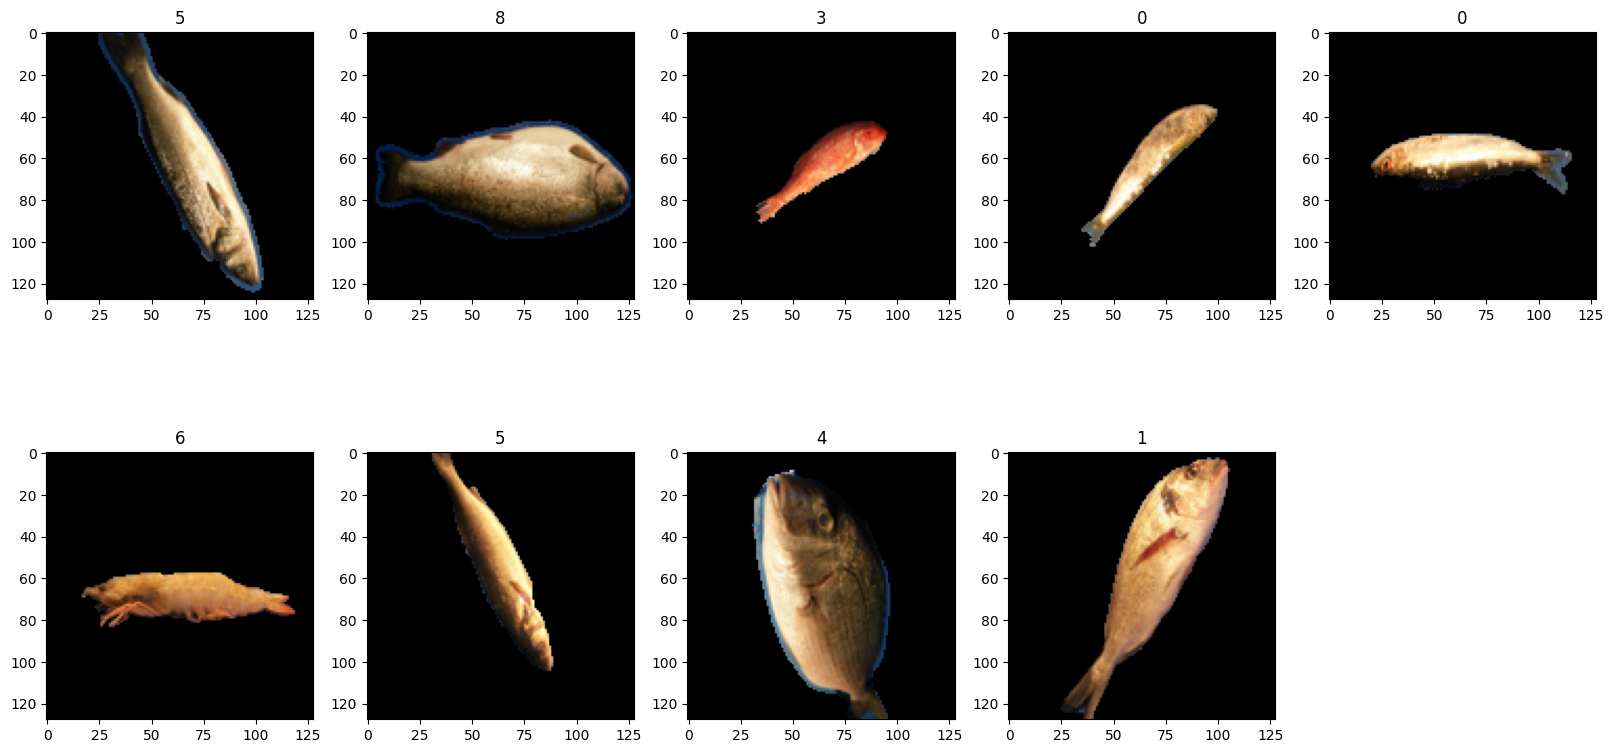

In [ ]:
# in ra các ảnh là tâm của các cluster
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[center_id[i]].reshape(128, 128, 3))
    # plt.title(i)
    plt.title(labels[center_id[i]])

C:\Users\duyen\AppData\Local\Temp\ipykernel_9168\4235388383.py:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, images_per_row, i+1)


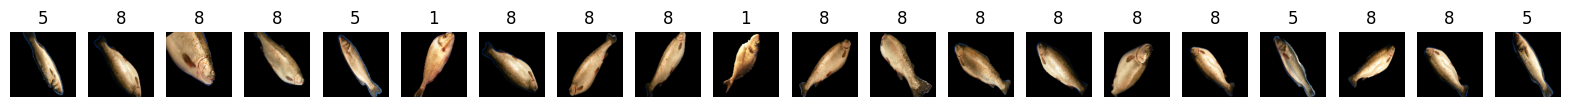

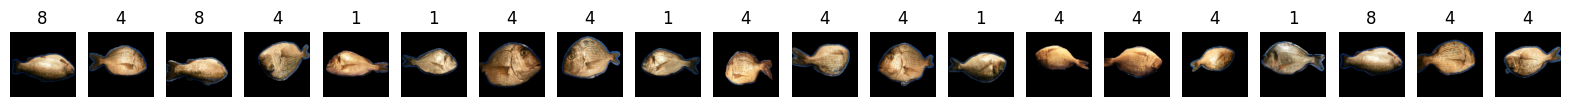

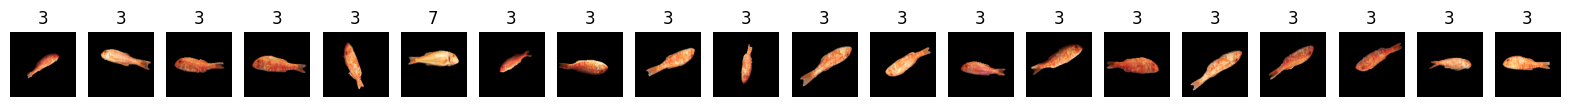

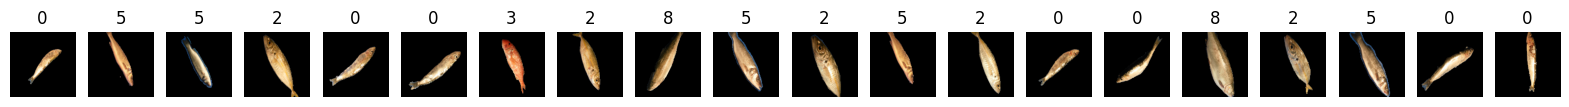

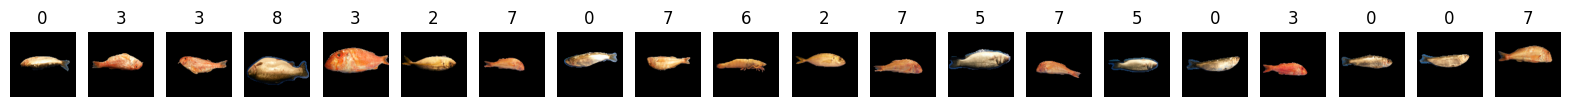

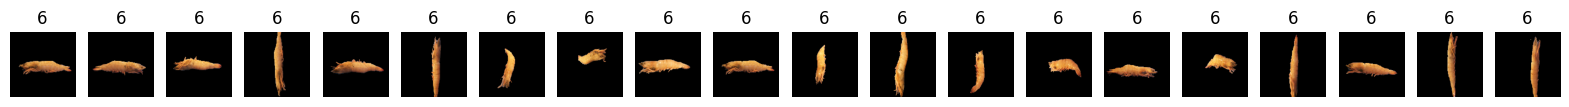

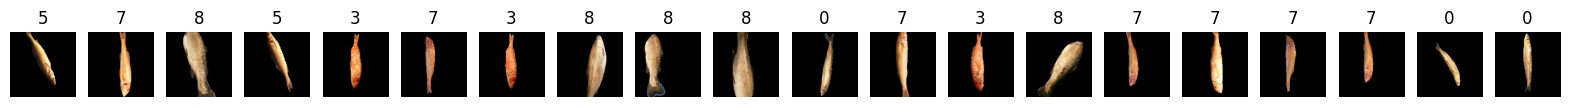

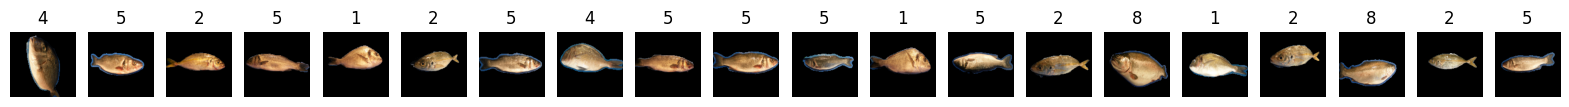

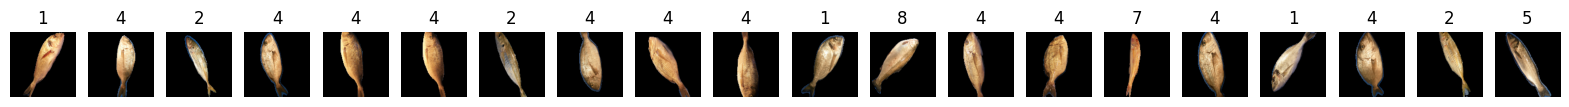

In [ ]:
import matplotlib.pyplot as plt

# Reshape cluster centers to match image dimensions
cluster_centers = np.array(kmeans.cluster_centers_)

num_clusters = cluster_centers.shape[0]
images_per_row = 20

# Display clusters
for cluster_id in range(num_clusters):
    cluster_center = cluster_centers[cluster_id]

    # Create a new row for each cluster
    plt.figure(figsize=(20, 1))
    
    # Get indices of images in the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]

    # Plot the cluster center as the first image in the row
    plt.subplot(1, images_per_row + 1, 1)
    plt.imshow(images[cluster_indices[0]].reshape(128,128,3))
    plt.title(labels[cluster_indices[0]])
    plt.axis('off')


    # Plot the images in the cluster
    for i, img_idx in enumerate(cluster_indices[:images_per_row]):
        img = images[img_idx]
        plt.subplot(1, images_per_row, i+1)
        plt.imshow(img.reshape(128,128,3))
        plt.title(labels[img_idx])
        plt.axis('off')

    plt.show()

# .------
-